In [147]:
import pandas as pd
import numpy as np
import math
import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from sklearn.cluster import KMeans
from haversine import Unit

In [17]:
demand_seasonality_data = pd.read_csv('demand_seasonalities.csv')
metro_areas_data = pd.read_csv('msa.csv')
demand_pmf_by_zip_data = pd.read_csv('zip3_pmf.csv')
price_to_ship_in_zip_data = pd.read_csv('order_shipment_matrix.csv')
zip_coordinates_data = pd.read_csv('zip3_coordinates.csv')

In [19]:
price_to_ship_in_zip_data['minimum_distance'] = np.array([0,51,151,301,601,1001,1401,1801])
price_to_ship_in_zip_data['maximum_distance'] = np.array([50, 150,300,600,1000,1400,1800, 50000])
price_to_ship_in_zip_data['Zone'] = [z[0] for z in price_to_ship_in_zip_data['Zone'].astype('str')]
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,51,150
2,3,19.05,151,300
3,4,24.15,301,600
4,5,28.73,601,1000
5,6,34.00,1001,1400
6,7,36.17,1401,1800
7,8,38.81,1801,50000


The growth in USA is projected to be median = 7.5%, min = 4% and max = 12%

In [23]:
df_coords_to_geo = gpd.GeoDataFrame(zip_coordinates_data, geometry= gpd.points_from_xy(zip_coordinates_data.Lon, zip_coordinates_data.Lat))
df_coords_to_geo

,ZIP3,Lat,Lon,geometry
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160)
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577)
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659)
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896)
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623)
...,...,...,...,...
887,995,60.970213,-151.140110,POINT (-151.14011 60.97021)
888,996,60.524385,-153.405946,POINT (-153.40595 60.52438)
889,997,65.359648,-151.894015,POINT (-151.89402 65.35965)
890,998,58.188334,-135.227811,POINT (-135.22781 58.18833)


Next, we get the map of the USA

In [135]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Atharva Ketkar\AppData\Local\Temp\ipykernel_95040\3432786234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

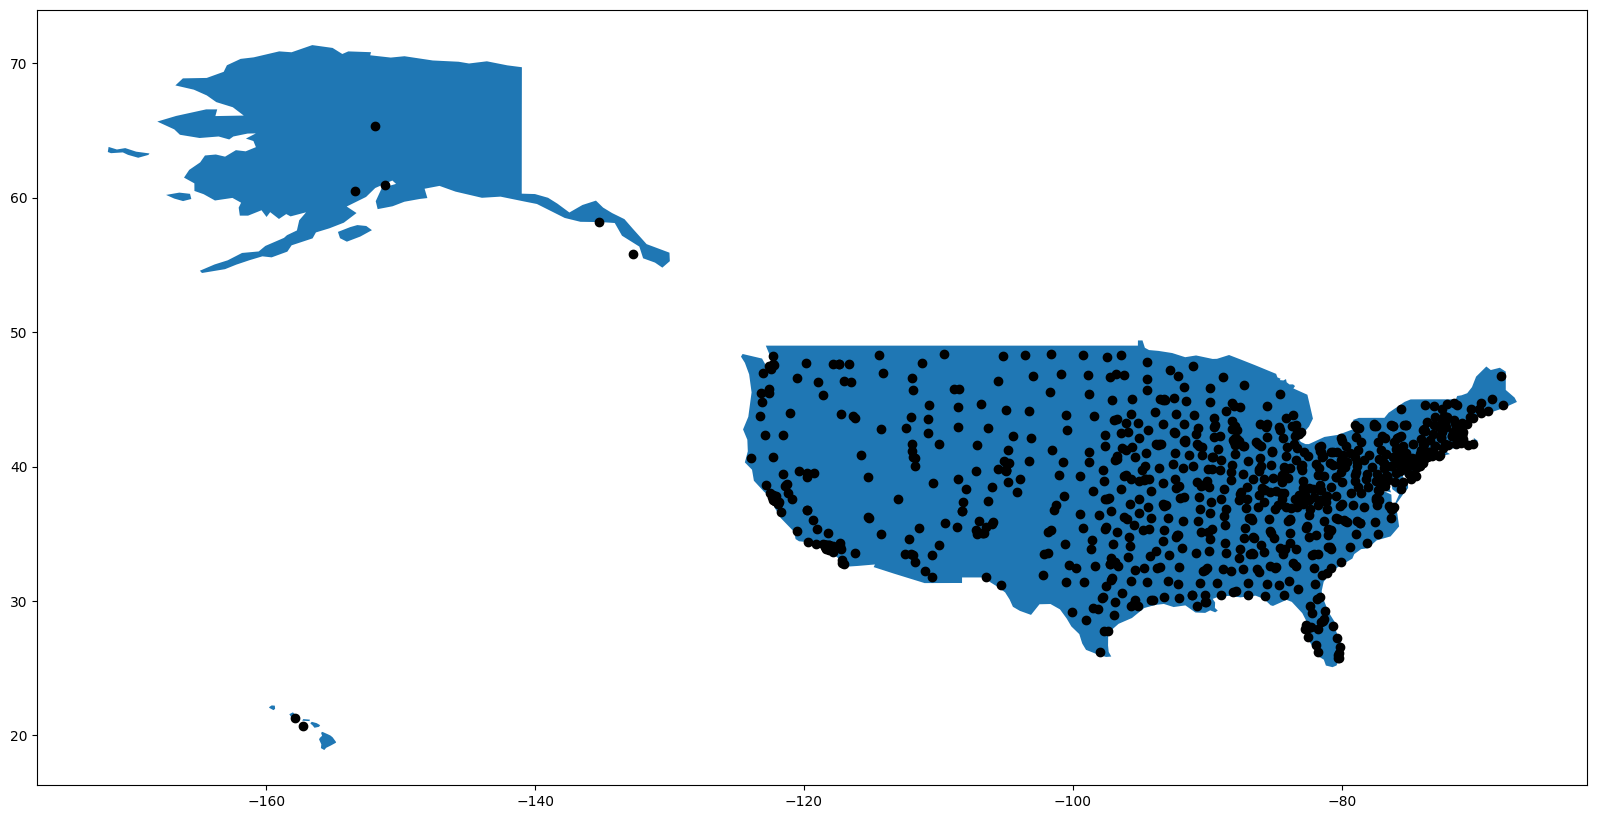

In [136]:
axis = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_coords_to_geo.plot(ax=axis, color = 'black')

There are 4 FCs: NY, Atlanta, Salt Lake City, and El Paso. So we have to cluster the points around these 4 as the cluster centroids.

In [148]:
clusters = zip_coordinates_data.loc[zip_coordinates_data['ZIP3'].isin([303, 134, 799, 841])]
clusters = clusters.loc[:,['Lat', 'Lon']]

coordinate_data = zip_coordinates_data.loc[:, ['Lat', 'Lon']]


id2fc = {id:zip for id,zip in enumerate([134, 303, 799, 841])}


def cluster_points(centroids, data):
    clusters = np.array(centroids)
    coordinate_data = np.array(data)
    new_data = pd.DataFrame(data, columns=['Lat', 'Lon'])
    sorted_points = []
    distances = []
    for x in coordinate_data:
        dists = []
        for centroid in clusters:
            dists.append(hs.haversine(centroid, x, unit= Unit.MILES))
        centroid_idx = np.argmin(dists)

        sorted_points.append(id2fc[centroid_idx])
        distances.append(dists[centroid_idx])
    
    new_data['centroid'] = sorted_points
    new_data['Distance'] = distances

    return new_data

clustered = cluster_points(clusters, coordinate_data)

In [149]:
clustered

,Lat,Lon,centroid,Distance
0,42.221598,-72.573558,134,152.844754
1,42.105773,-72.583739,134,155.861249
2,42.396595,-73.237576,134,116.977838
3,42.578956,-72.540044,134,146.032424
4,42.566233,-71.696724,134,187.899459
...,...,...,...,...
887,60.970213,-151.140110,841,2155.791513
888,60.524385,-153.405946,841,2216.540926
889,65.359648,-151.894015,841,2305.416818
890,58.188334,-135.227811,841,1581.003726


In [150]:
clustered['centroid'].value_counts()

centroid
303    328
134    285
841    191
799     88
Name: count, dtype: int64

Thus we have allotted each location to its closest FC. Atlanta will serve 369 locations, New York will serve 248, Utah 167, and Texas 108.

In [141]:
df_geo = pd.merge(df_coords_to_geo, clustered, how= 'left', on= ['Lat', 'Lon'])

centroid
303    369
134    250
841    167
799    108
Name: count, dtype: int64

<Axes: >

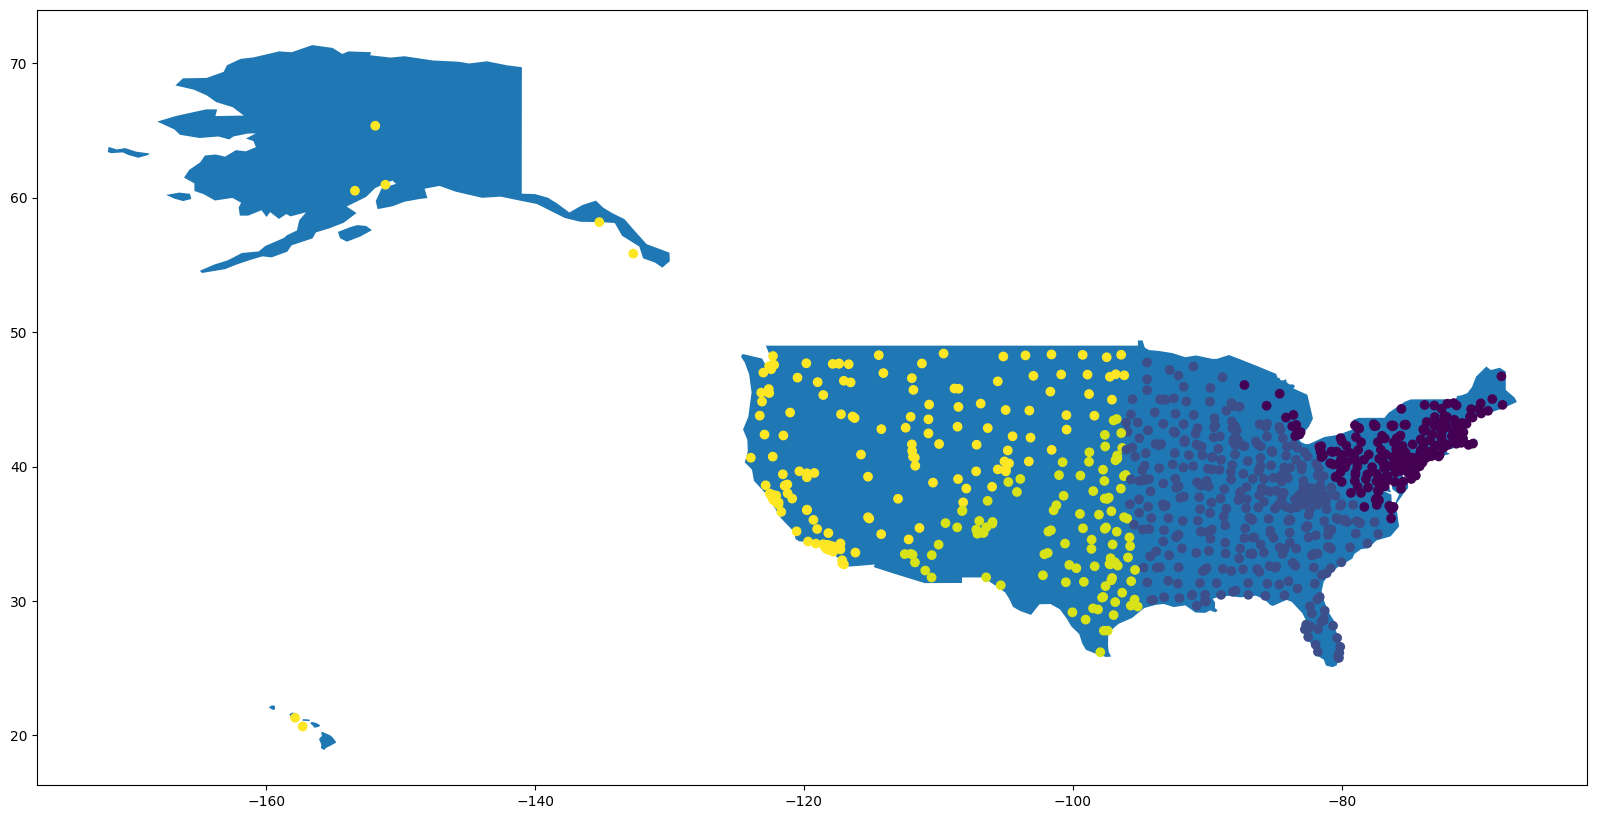

In [143]:
axis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_geo.plot(ax = axis2, c= df_geo['centroid'])